### How to simulate a pathway simple promoter (+rbs?) + enzyme with kinetics using Tellurium and Antinomy

A model template has been initially generated using COPASI, although we will convert it into Antinomy model language in order to define modularly the model.

In [69]:
import tellurium as te
import numpy as np

Load the SBML template into Tellurium and simulate

In [277]:
pw = te.loadSBMLModel('prom_enzyme_temp2.xml')

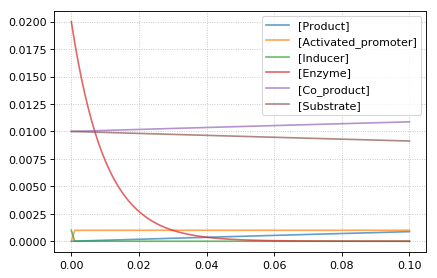

In [278]:
results = []
for k in range(1, 2):
    pw.reset()
    s = pw.simulate(0, 0.1, 100)
    results.append(s)
    pw.plot(s, show=False, alpha=0.7)
te.show()

In [279]:
# Convert into Antinonmy
print(pw.getAntimony())

// Created by libAntimony v2.9.4
function Constant_flux__irreversible(v)
  v;
end

function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

function Hill_Cooperativity(substrate, Shalve, V, h)
  V*(substrate/Shalve)^h/(1 + (substrate/Shalve)^h);
end


model *New_Model()

  // Compartments and Species:
  compartment Cell;
  species Substrate in Cell, Product in Cell, Co_product in Cell, Enzyme in Cell;
  species Inducer in Cell, Activated_promoter in Cell;

  // Reactions:
  Induction: Inducer => Activated_promoter; Cell*Hill_Cooperativity(Inducer, Induction_Shalve, Induction_V, Induction_h);
  Expression: Activated_promoter => Enzyme; Cell*Expression_k1*Activated_promoter;
  Leakage:  => Enzyme; Cell*Constant_flux__irreversible(Leakage_v);
  Degradation: Enzyme => ; Cell*Degradation_k1*Enzyme;
  Catalysis: Substrate => Product + Co_product; Cell*Henri_Michaelis_Menten__irreversible(Substrate, Catalysis_Km, Catalysis_V);

  // Species initiali

Define a model definition that will connect three genes and promoters

In [286]:
def modelTemplate(nsteps):
    antinom = """
    // Created by libAntimony v2.9.4
        function Constant_flux__irreversible(v)
          v;
        end

        function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
          V*substrate/(Km + substrate);
        end

        function Hill_Cooperativity(substrate, Shalve, V, h)
          V*(substrate/Shalve)^h/(1 + (substrate/Shalve)^h);
        end


        model New_Model()

          // Compartments and Species:
          compartment Cell;
          species Substrate in Cell, Product in Cell, Enzyme in Cell;
          species Inducer in Cell, Activated_promoter in Cell;

          // Reactions:
          Induction: Inducer => Activated_promoter; Cell*Hill_Cooperativity(Inducer, Induction_Shalve, Induction_V, Induction_h);
          Expression: Activated_promoter => Enzyme; Cell*Expression_k1*Activated_promoter;
          Leakage:  => Enzyme; Cell*Constant_flux__irreversible(Leakage_v);
          Degradation: Enzyme => ; Cell*Degradation_k1*Enzyme;
          Catalysis: Substrate => Product; Cell*Henri_Michaelis_Menten__irreversible(Substrate, Catalysis_Km, Catalysis_V);

         // Species initializations:
          Substrate = 0.5;
          Product = 0;
          Enzyme = 0;
          Inducer = 1;
          Activated_promoter = 0;

          // Compartment initializations:
          Cell = 1;

          // Variable initializations:
          Induction_Shalve = 0.01;
          Induction_V = 10000;
          Induction_h = 4;
          Expression_k1 = 100;
          Leakage_v = 0.0001;
          Degradation_k1 = 10;
          Catalysis_Km = 0.1;
          Catalysis_V = 0.1;

          // Other declarations:
          const Cell;

        end
        
        """
    antinom += "model *Big_Model()"+"\n"
    for i in np.arange(nsteps):
            antinom += "\t"+"m%d: New_Model();" % (i+1,)
            antinom += "\n"
    for i in np.arange(nsteps-1):
            antinom += "\t"+"m%d.Product is m%d.Substrate;" % (i+1, i+2)
            antinom += "\n"
    antinom += "end\n"
    return te.loada(antinom)

In [299]:
m = modelTemplate(5)
m['m3_Degradation_k1'] = 0.1
m['m2_Degradation_k1'] = 0.1
m['m5_Degradation_k1'] = 0.01
m['m5_Catalysis_Km'] = 1

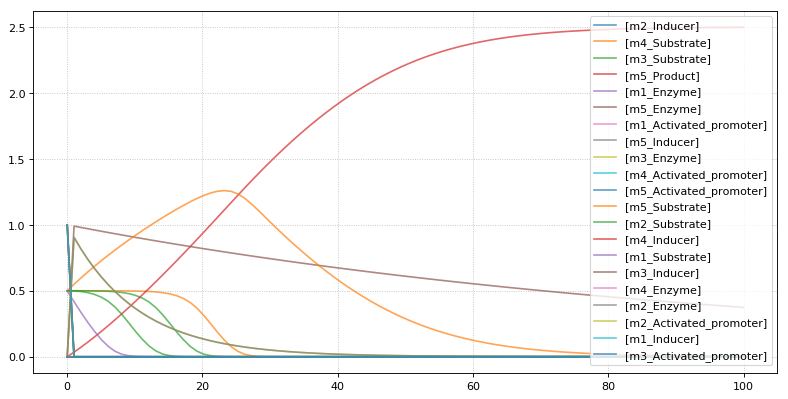

In [306]:
mod = te.loada(antimon)
mod = m
#mod.integrator = 'gillespie'
#mod.integrator.seed = 1234
results = []
for k in range(1, 2):
#    mod.integrator.seed = np.random.randint(1000)
    mod.reset()
    s = mod.simulate(0, 100, 100)
    results.append(s)
    mod.plot(s, show=False, alpha=0.7, loc='upperleft', figsize=(12,6))
te.show()